## Introduction to reinforcement learning

### Summary and setup

TBC - GitHub codespaces?

### Questions

- What is reinforcement learning?
- How can a computer "agent" learn?
- What are the strengths and weaknesses of some popular reinforcement learning techniques?

### Objectives

- Understand how to train an agent using three different approaches: SARSA, Q-learning and Monte Carlo
- Learn how to use the gymnasium library to create a simple environment for the agent to learn from
- Visualise the impact that the different approaches to learning have on the behaviour of the agent

### Prerequisites

- TBC

### 1. Background

Reinforcement learning is a field of machine learning, distinct from both supervised and unsupervised learning, that may be described as a "computational approach to understanding and automating goal-directed learning and decision-making" [(Sutton and Barto, 2015)](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf). 


It begins with a simulation of an agent and an environment. The agent receives rewards, which may be positive or negative, from the environment in response to the actions it takes. By processing these responses, and by trial and error, the agent learns to optimise its decision-making by maximising the total reward it obtains. 

#### Ancient history

As explained by [Sutton and Barto (2015)](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf), modern reinforcement learning techniques emerged from two main threads: one focussed on animal psychology and trial-and-error learning that informed the earliest experiments with artificial intelligence; the other on "optimal control", or how to design a system that could optimise the performance of a dynamical system. 

Although these two threads were mostly independent of one another, they occasionally intertwined on research related to temporal difference methods, and these ideas finally all came together in the late 1980s. A key milestone in this synthesis was the publication of [Chris Watkins's PhD thesis](https://www.cs.rhul.ac.uk/~chrisw/new_thesis.pdf), which introduced the concept of Q-learning. 

Applying these ideas to real-world problems remained a formidable computational challenge. An [early effort, by Gerald Tesauro](https://direct.mit.edu/neco/article/6/2/215/5771/TD-Gammon-a-Self-Teaching-Backgammon-Program), to harness the power of artificial neural networks to enable an agent to learn the game of backgammon brought further attention to the field. By 1994, the agent was playing with skills that were competitive with the best human players in the world. 

#### Modern history

As with many other fields of research, in recent years deep neural networks (i.e. artificial neural networks with many hidden layers) and advances in computational infrastructure have facilitated breakthroughs in reinforcement learning. In 2015, a team from [Google Deepmind published details](https://www.nature.com/articles/nature14236) of what they called a deep Q-network, a deep convolutional neural network which had learned to play a variety of classic Atari video games using only the pixels from an Atari emulator and the game score as inputs, achieving comparable skill to a human games tester. 

![Schematic of Deepmind's network](../../img/atari.png)

Depending on the Atari game under test, the number of possible legal actions at any moment in a game ranges from four to 18. Google Deepmind went on to develop deep neural networks that could out-compete the worlds' best human players at Chess, Go and Shogi, where the number of actions is at any stage is much higher, and discovering an optimal policy is consequently a much more complex task. 

#### Useful applications

Beyond mastering ever-more sophisticated games, reinforcement learning has shown great promise in many domains including [biotechnology](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007783), [efficient computer chip design](https://www.cl.cam.ac.uk/~ey204/teaching/ACS/R244_2021_2022/papers/Mirhoseini_NATURE_2021.pdf), and the [control of tokamak plasmas]() in nuclear fusion processes. 

What these diverse examples have in common is that in each case an agent learns through experimentation over repeated episodes, each consisting of a sequence of states, actions and rewards that continues until some terminal state is reached and the next episode begins. 

![Diagram of state-action-reward-state-action flow](../../img/flow.png)

An episode may be a level in a video game or a scientific experiment - the agent tries to maximise whatever you define as the total reward, no matter the context. However, there are important distinctions between common implementations of this idea that affect how the agent learns, and what its behaviour will be as a result. 

Although we focus on episodic examples in this session, similar approaches are applicable in continuing scenarios where the experience of an agent does not necessarily reach an obvious terminal state. 

#### Recommended reading:

- [Reinforcement Learning: An Introduction](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf), by Richard S. Sutton and Andrew G. Barto
- [Spinning Up in Deep Reinforcement Learning](https://spinningup.openai.com/en/latest/), a training resource by Josh Achiam from OpenAI
- [Gymnasium documentation](https://gymnasium.farama.org/), a tool for creating reinforcement learning environments

#### Introduction

This session will demonstrate how to put these abstract ideas into practice in the context of a very simple example: the gymnasium library's [cliff-walking environment](https://gymnasium.farama.org/environments/toy_text/cliff_walking/). By the end we will have compared and contrasted some of the most popular ways to configure a reinforcement-learning process. 

#### Imports

We begin by loading some python libraries to help with this task. 

In [1]:
import numpy as np

import gymnasium as gym

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

%matplotlib widget

### 2. Environment

Having loaded `gym`, we can build the environment with only one line of code. We initialise the environment's `render_mode` to be `rgb_array` to help us visualise the environnment later.

In [3]:
env = gym.make('CliffWalking-v0', render_mode ='rgb_array')

From the environment's documentation, we know that it consists of a two-dimensional grid of 4 rows and 12 columns, making a total of 48 possible locations - or states - at which our agent may be located at any particular time step. Our agent can move horizontally or vertically but not diagonally, so it has four potential actions it can take at any one step. 

We store these values for usage later.

In [4]:
n_states = 48
grid_shape = (4, 12) # (Rows, columns)

n_actions = 4
env.action_lookup = {0: 'Up', 1: 'Right', 2: 'Down', 3: 'Left'}

### 3. Temporal difference agents

We begin with temporal difference agents, which are so-called because they update their understanding of the environment at every time step (in contrast to other types of agent which perform the update at the end of each episode, which we will get to later).

Below is some code to create and train two types of temporal difference agent: first we will walk through the creation of a SARSA agent and then modify it slightly to produce a Q-learning agent. 

We will then demonstrate training these agents on the cliff-walking environment and analyse the differences in behaviour produced by the two approaches.

----

#### Note

A key assumption underlying the approaches in this session is that they are operating within a fully observable Markov decision process. This means that all information relevant to the decision-making process at each time step is encoded in the state. We will encounter some approaches that can handle partially observable Markov decision processes in the next session. 

----

#### a) SARSA agent

First we will initialise our agent as a Python class, with some important information about how the agent will behave and what choices it can take at each time step set as instance variables. 

The agent will have access to its environment `env`, with the variables `n_states` and `n_actions` are the number of possible states and actions associated with that environment, detailed above. 

The `gamma` (discount factor), `alpha` (learning rate) variables play an important role in determining how the agent learns, and by default we set these to sensible values. 

----
#### Remember
Discounting defines how an agent balances short-term and long-term rewards. If `gamma` is set to 1, a reward many steps in the future is worth just as much as an immediate reward, meaning that the agent may not learn to reach its goal in an efficient manner. If on the other hand it is set to 0, the agent is only concerned about the next reward and may forgo large future rewards to obtain a small reward straight away. Setting the discount factor to 0.95 is a common starting point. 

----

Because both the state and action spaces are discrete and relatively small we can learn a complete tabular value function. 

-----
#### Note
A tabular value function is like a table with an entry for each combination of state-action pairs. The values that comprise these entries are estimates of the expected discounted future return the agent will receive if it takes that particular action from that state, and is learned through trial and error during the training process. The function in this simple case is just looking up the value in the table.

-----

Therefore we initialise our Q function (`Q_func`) as a numpy table of zeros of size `(n_states, n_actions)`.

In [6]:
class TD_agent():
    def __init__(self, env, n_states, n_actions, gamma=0.95, alpha=0.01):
        self.env = env
        self.n_states = n_states
        self.n_actions = n_actions
        self.gamma = gamma
        self.alpha = alpha
        self.Q_func = np.zeros((n_states, n_actions))

#### Policy

So far, our agent knows how many states it may be in and how many actions it may be able to take. But what it really needs is a **policy** - a means of determining which action to take based on the state it is in. 

We will define this policy as the "epsilon-greedy policy". This code uses the `np.random.random` and `np.random.choice` functions to take a random action with probability determined by the `explore_rate` parameter (also known as epsilon). 

With probability `1 - explore_rate` we take the "greedy" action, i.e. the one that has the highest entry in our tabular value function.

----

#### Remember

A greedy policy is one that always takes the action that promises the highest total discounted return. This is a good option for an agent that knows the environment well, but for one that is just getting it is likely to be a poor choice.

----

An epsilon-greedy policy is designed to balance random exploration of the environment with exploitation of knowledge already gathered about the environment, and the `explore_rate` is typically reduced as the agent gets to know the environment better - although in this session we will just be holding it constant. 

In [7]:
def epsilon_greedy_policy(self, state, explore_rate):
    """Choose an action based on the agent's value function and the current explore rate

    Params
    ======
        state (int): the current state given by the environment
        explore_rate (float): the probability of taking a random action

    Returns
    =======
        int: the action to be taken
    """
    if np.random.random() < explore_rate:
        # In this case the agent will randomly choose an integer from 0 to 3
        action = np.random.choice(range(self.n_actions))
    else:
        # Otherwise the agent chooses the action that has the highest value 
        # corresponding to its state in the Q function
        action = np.argmax(self.Q_func[state])
    return action

We add this function to the Python class:

In [8]:
TD_agent.policy = epsilon_greedy_policy

But a key ingredient is missing. Our agent needs to be able to learn what values to put in its Q function. At the moment it has nothing but zeros!

Our first update rule - known as SARSA - takes a transition, which contains: 

- the **S**tate the agent is in at time step `t`
- the **A**ction it takes at `t` 
- the **R**eward it receives from the environment for taking that action
- the **S**tate it will be in at `t+1` 
- the **A**ction it will take having moved to the new state at `t+1`, according to its policy (which for now is the epsilon-greedy policy)
- and the `done` variable which tells us whether the current transition is the last one in the current episode. 

The `done` variable will be `False` if the episode has not finished and `True` if it has. 

We then update our agent's value function, with the magnitude of the update being dictated by the agent's learning rate `alpha`. 

The `(1 - done)` term in the update rule means that the estimate of the future return is not incorporated if the episode finishes on this transition (if the episode finishes there can be no additional return in the future!). This is because in Python `True` and `False` are aliases for the integers 1 and 0 in mathematical operations such as addition and multiplication. 

In [9]:
class SARSA_agent(TD_agent):
    def __init__(self, env, n_states, n_actions, gamma=0.95, alpha=0.01):
        super().__init__(env, n_states, n_actions, gamma, alpha)

    def update_Q(self, transition):
        """Update the agent's Q function based on the experience in transition
        
        Params
        ======
            transition (int, int, float, int, int, bool): values to define a SARSA transition
        """

        # First we unpack the SARSA data from the transition:
        state, action, reward, next_state, next_action, done = transition

        # Then we use this data to update the Q function:
        value_of_current_state = self.Q_func[state, action]
        discounted_value_of_next_state = self.gamma * self.Q_func[next_state, next_action] * (1 - done)
        self.Q_func[state, action] += self.alpha * (reward + discounted_value_of_next_state - value_of_current_state)


#### Training loop

At last, we're ready to train the agent! We create a helper function that takes an agent and an environment as arguments, then loops over a pre-determined number of episodes trying to define an optimal policy. 

#### Assignment questions

As you read through the code below, try to answer the following questions:

- Where is the agent's policy queried to get the next action?
- Where is the action applied to the environment?
- Where is the state, action, reward, next_state, next_action constructed?

#### Solutions

- Line 12: `self.policy(next_state, explore_rate)`
- Line 11: `self.env.step(action)`
- Line 13: `transition = (state, action, reward, next_state, next_action, done)`

In [10]:
def run_episode(self, explore_rate):
    """Train the agent for the duration of an episode
    
    Params
    ======
        explore_rate (float): the epsilon in the agent's policy-making process

    Returns
    =======
        float: the cumulative reward the agent has received in the episode
    """
    episode_reward = 0 # sum the reward we get this episode
    episode_transitions = [] # memory of all transitions seen in this episode
    done = False # has the episode finished?
    
    state, prob = self.env.reset() # Reset env to initial state

    action = self.policy(state, explore_rate) # Initialise the agent

    while not done: # run the episode until a terminal state reached
        next_state, reward, done, info, prob = self.env.step(action) # take an action and get the resulting state from the env
        next_action = self.policy(next_state, explore_rate) # get the next action to apply from agent's policy
        transition = (state, action, reward, next_state, next_action, done) # create the SARSA transition
        episode_transitions.append(transition) # add to the memory
        self.update_Q(transition) # use the transition values to update the agent's Q function
            
        # Prepare for next step:
        state = next_state
        action = next_action

        # Keep track of cumulative reward:
        episode_reward += reward
    
    self.latest_episode_transitions = episode_transitions

    return episode_reward

TD_agent.run_episode = run_episode

def train_TD_agent(self, explore_rate, n_episodes=10001):
    training_returns = []
    for episode in range(n_episodes): # For each episode:
        episode_reward = self.run_episode(explore_rate)
        training_returns.append(episode_reward)
        if episode % 1000 == 0: # print results of current episode
            print('episode:', episode, ', explore_rate:', explore_rate, ', return:', episode_reward)
    return training_returns

TD_agent.train = train_TD_agent
        

Just one more thing: we'd like to be able to visualise the learned behaviour of the agent as an animation. We can do this by running a final episode with an `explore_rate` of `0`, which will record the actions the agent decided to take at each step as part of the transitions stored in the `latest_episode_transitions` variable. By rendering the environment as an `rgb_array` following each action we can build up a series of images that we will animate shortly:

In [11]:
def get_learned_policy_as_animation_frames(self, ax):
    """Convert agent's learned policy into an animation
    
    Params
    ======
        ax: a pyplot axis object on which to display the animation

    Returns
    =======
        list of animation frames rendered on the supplied pyplot axis
    """
    self.run_episode(explore_rate=0)
    state, prob = self.env.reset()
    frames = []
    ax.imshow(self.env.render())
    for i, transition in enumerate(self.latest_episode_transitions):
        if i < 50:
            action = transition[1] # The action is stored at index 1 (i.e. after 0) in the S*A*RSA transition
            self.env.step(action)
            frame = ax.imshow(self.env.render(), animated=True)
            frames.append([frame])
        else:
            print('Agent did not learn how to get to goal in under 50 steps!')
    return frames
    
TD_agent.get_learned_policy_as_animation_frames = get_learned_policy_as_animation_frames

Now we can train our SARSA agent with an explore rate of 0.05.

In [12]:
sarsa_agent = SARSA_agent(env, n_states, n_actions)
print('TRAINING')
SARSA_training_returns = sarsa_agent.train(explore_rate=0.05) # train the agent

TRAINING
episode: 0 , explore_rate: 0.05 , return: -504
episode: 1000 , explore_rate: 0.05 , return: -43
episode: 2000 , explore_rate: 0.05 , return: -28
episode: 3000 , explore_rate: 0.05 , return: -24
episode: 4000 , explore_rate: 0.05 , return: -15
episode: 5000 , explore_rate: 0.05 , return: -15
episode: 6000 , explore_rate: 0.05 , return: -17
episode: 7000 , explore_rate: 0.05 , return: -15
episode: 8000 , explore_rate: 0.05 , return: -15
episode: 9000 , explore_rate: 0.05 , return: -15
episode: 10000 , explore_rate: 0.05 , return: -115


Let's find out what the agent learned!

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


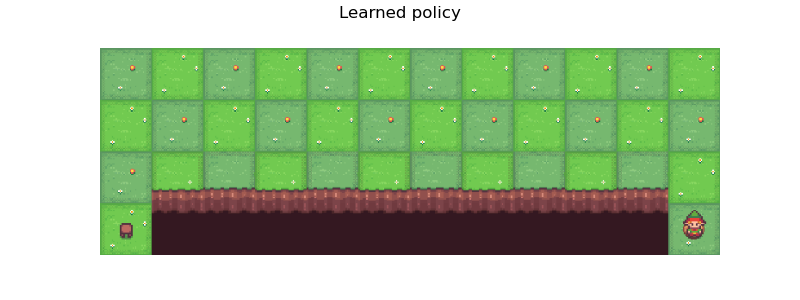

In [13]:
fig, ax = plt.subplots(figsize=(8, 3))
plt.axis('off')
plt.suptitle('Learned policy')
frames = sarsa_agent.get_learned_policy_as_animation_frames(ax)
ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True, repeat=False);

If the training has worked properly, the agent should navigate to the goal in the bottom right of the image, steering clear of the cliff at the bottom. 

We can analyse the values in the agent's Q function to understand why it behaves in this way. 

To help with this, first we construct a mask to conceal the areas in the grid where the agent cannot "be", which is anywhere in row 3 apart from the starting point; if the agent gets to the end (the last grid square in row 3) the episode finishes immediately, and if they fall over the cliff they are automatically returned to the starting point. We can use numpy to create this mask as follows:

In [14]:
mask = np.zeros(grid_shape, dtype=bool)
mask[3,1:] = True
env.mask = mask

Now we can plot a heatmap for the value of each possible action for each state in the agent's state-action value function. The agent has learned that moving left, up or right is mostly harmless (with one notable exception), but moving down can be problematic. 

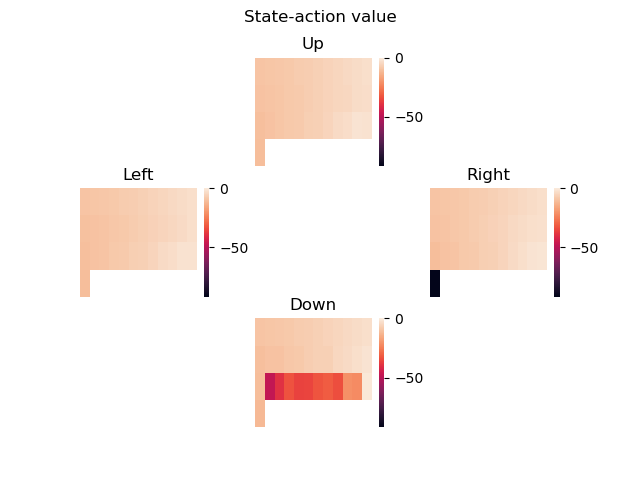

In [16]:
def plot_state_action_values(agent):
    """Display the agent's learned Q values as small-multiple heatmaps"""
    nrow = 3
    ncol = 3
    min_value = agent.Q_func.min()
    max_value = agent.Q_func.max()
    fig, axes = plt.subplots(nrow, ncol)
    plt.suptitle('State-action value')
    for ax in axes.flatten():
        ax.axis('off')
    coords_lookup = {
        'Up': (0, 1),
        'Right': (1, 2),
        'Down': (2, 1),
        'Left': (1, 0)
    }
    for idx, title in agent.env.action_lookup.items():
        coords = coords_lookup[title]
        ax = axes[coords]
        ax.set(title=title)
        Q_values = agent.Q_func[:, idx].reshape(grid_shape)
        sns.heatmap(Q_values, ax=ax, vmin=min_value, vmax=max_value, mask=agent.env.mask)

plot_state_action_values(sarsa_agent)

Similarly, we can plot the maximum value for the agent of being in each possible state, with the action it would take on the basis of its Q function alone (exploitation rather than exploration):

ValueError: cannot reshape array of size 48 into shape (4,4)

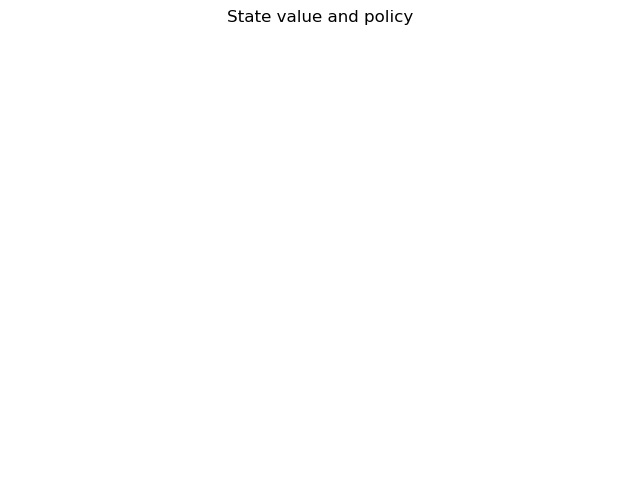

In [35]:
def plot_state_value_and_policy(agent):
    """Display the Q value for each state and the agent's optimum action from that state"""
    fig, ax = plt.subplots()
    plt.suptitle('State value and policy')
    ax.axis('off')
    max_value_by_state = np.max(agent.Q_func, axis=1).reshape(grid_shape)
    policy_by_state = np.array([agent.env.action_lookup[action][0] for action in np.argmax(agent.Q_func, axis=1)]).reshape(grid_shape)
    sns.heatmap(max_value_by_state, annot=policy_by_state, fmt='', mask=agent.env.mask, ax=ax)
    
plot_state_value_and_policy(sarsa_agent)

A line chart showing how the episode returns increased over the training period shows that the agent continued to make mistakes even as its knowledge of the environment improved. This is because it continued to take random actions with probability `explore_rate` (which remained constant at `0.05`):

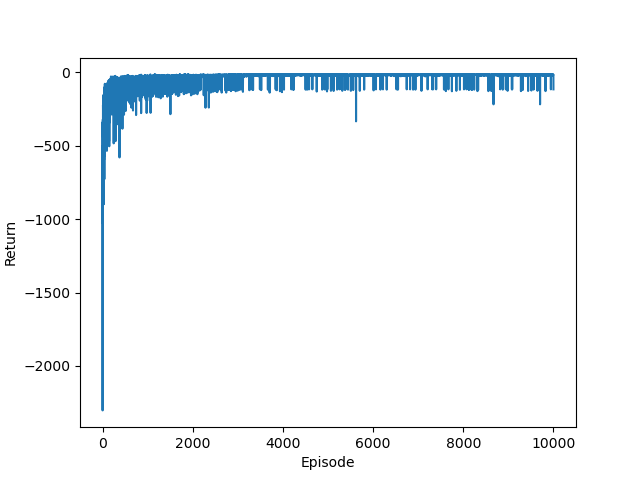

In [23]:
fig, ax = plt.subplots()
plt.xlabel('Episode')
plt.ylabel('Return')
sns.lineplot(SARSA_training_returns, ax=ax);

### b) Q-learning agent

We will now modify our agent so that it does Q learning. All we need to do is adjust the update function slightly:

In [24]:
class QLearning_agent(TD_agent):
    def __init__(self, env, n_states, n_actions, gamma=0.95, alpha=0.01):
        super().__init__(env, n_states, n_actions, gamma, alpha)

    def update_Q(self, transition):
        """Update the agent's Q function based on the experience in transition
        
        Params
        ======
            transition (int, int, float, int, int, bool): values to define a SARSA transition
        """

        # First we unpack the SARSA data from the transition:
        state, action, reward, next_state, next_action, done = transition

        # Then we use this data to update the Q function:
        value_of_current_state = self.Q_func[state, action]
        discounted_maximum_value_of_next_state = self.gamma * np.max(self.Q_func[next_state]) * (1 - done)
        self.Q_func[state, action] += self.alpha * (reward + discounted_maximum_value_of_next_state - value_of_current_state)


#### Assigment question:

How is this update rule different from the SARSA one above?

#### Solution

The agent's Q function is updated on the basis of the maximum possible value arising from the next state, regardless of what the next action is determined to be. 

The updating policy may therefore be described as greedy, while the acting policy continues to be epsilon-greedy. Because of this mismatch, Q-learning may be described as "off-policy". 

In contrast, SARSA agents are "on-policy": the updating policy matches the acting policy. 

To train an agent with this new policy, we create a new instance of the updated `TD_agent` class:

In [25]:
q_learning_agent = QLearning_agent(env, n_states, n_actions)
print('TRAINING')
Q_learning_returns = q_learning_agent.train(explore_rate = 0.05) # train the agent

TRAINING
episode: 0 , explore_rate: 0.05 , return: -1608
episode: 1000 , explore_rate: 0.05 , return: -37
episode: 2000 , explore_rate: 0.05 , return: -28
episode: 3000 , explore_rate: 0.05 , return: -13
episode: 4000 , explore_rate: 0.05 , return: -13
episode: 5000 , explore_rate: 0.05 , return: -14
episode: 6000 , explore_rate: 0.05 , return: -14
episode: 7000 , explore_rate: 0.05 , return: -15
episode: 8000 , explore_rate: 0.05 , return: -13
episode: 9000 , explore_rate: 0.05 , return: -13
episode: 10000 , explore_rate: 0.05 , return: -13


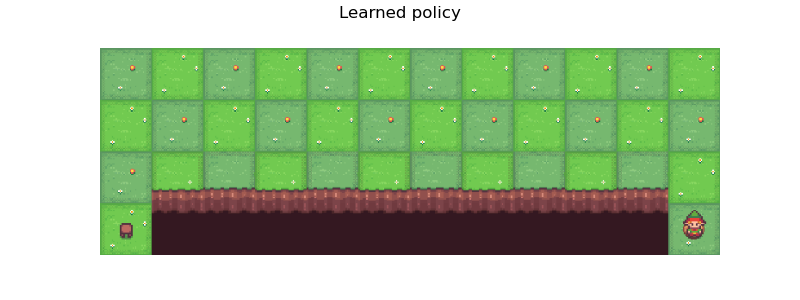

In [26]:
fig, ax = plt.subplots(figsize=(8, 3))
plt.axis('off')
plt.suptitle('Learned policy')
frames = q_learning_agent.get_learned_policy_as_animation_frames(ax)
ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True, repeat=False);

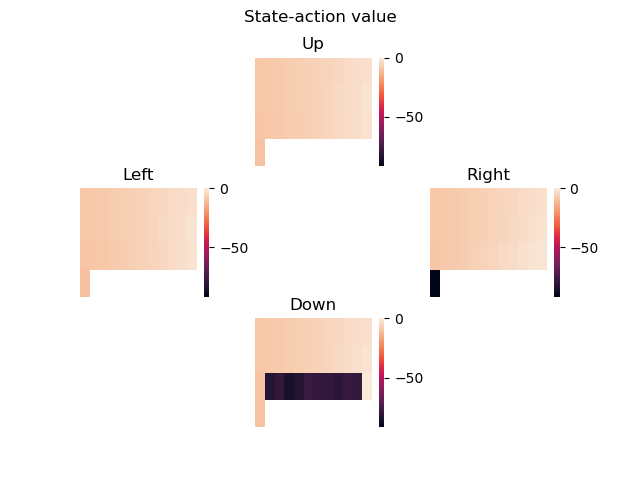

In [27]:
plot_state_action_values(q_learning_agent)

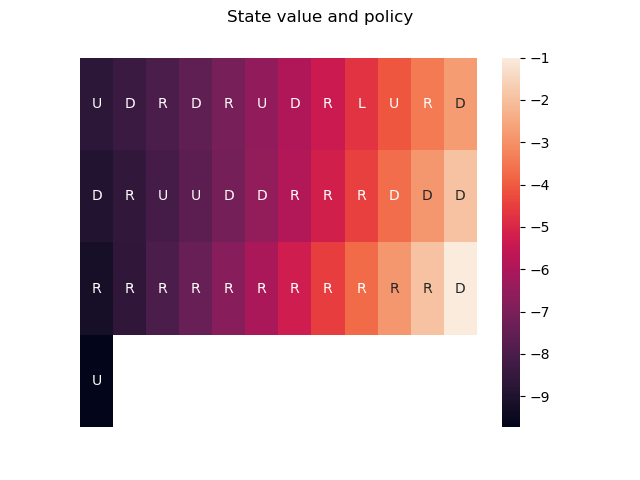

In [20]:
plot_state_value_and_policy(Q_agent)

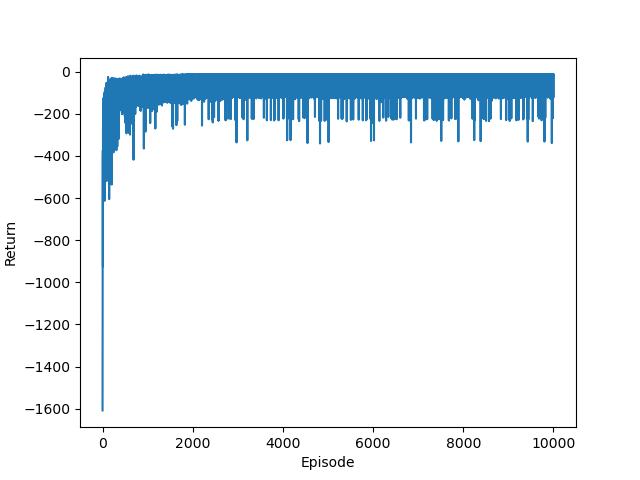

In [28]:
fig, ax = plt.subplots()
plt.xlabel('Episode')
plt.ylabel('Return')
sns.lineplot(Q_learning_returns, ax=ax);

----
#### Remember
Both SARSA and Q-learning agents use bootstrapping to update their value functions, i.e. they use their current value function to estimate future returns and then iteratively update their value functions at each time step. The full update for the SARSA agent looks like this: 

$$ Q(s_t, a_t) = Q(s_t, a_t) + α(r_t + γQ(s_{t+1}, a_{t+1}) - Q(s_t, a_t)) $$

Let's break this statement down into its components. We have the immediate reward at time *t* plus the discounted expected future return from the subsequent timestep onwards:

$$ r_t + γQ(s_{t+1}, a_{t+1}) $$

This can be thought of as our new point estimate of the value of having taken a particular action from the state the agent was at at *t*. We calculate the difference between this and our previous estimate, which is just the relevant entry in the table: 

$$ Q(s_t, a_t) $$

And the value of the learning rate *α* determines how responsive our agent is to these new estimates, i.e. what proportion of this increase or decrease in our estimated value we save in the tabular value function: 

$$ α(r_t + γQ(s_{t+1}, a_{t+1}) - Q(s_t, a_t)) $$

The Q-learning agent updates its value function with one key difference, using the maximum value it could achieve from the next state from any possible action (i.e. the greedy policy), rather than the action it will actually take (in our example, the epsilon-greedy policy):

$$ γ\max_a\> Q(s_{t+1}, a) $$ 

The full update function for the Q-learning agent is therefore: 

$$ Q(s_t, a_t) = Q(s_t, a_t) + α(r_t + γ\max_a\> Q(s_{t+1}, a) - Q(s_t, a_t)) $$

### Assignment questions:
1. What is the final return (in the test episode) of the SARSA and Q learning agents?
2. What differences do you notice in the learned behaviours? Why are they different?
3. What does the region of the state-action plot with very low value correspond to?
4. Try increasing the explore rate for each agent, e.g. to 0.3. What is the effect on the behaviour of each agent? (Remember to run the relevant cell to set the agent's update rule to either Q learning or SARSA)

### Solutions:
1. `SARSA_training_returns[-1]` and `Q_training_returns[-1]`
2. The Q-learning agent has found a more efficient route to the goal - one that steers it along the cliff edge - due to the decoupling of its behaviour and target policies. Constrastingly, the SARSA agent steers clear of the cliff because it updates its value function while factoring in that with probability `epsilon` it will choose a random action, i.e. one that may lead it over the edge of the cliff, whereas the Q-learning agent performs its updates on the basis that it is possible for it not to fall off, even if in practice it does do so more often. You can also see this distinction in the two returns charts: the Q-learning agent earns on average lower rewards even after many episodes of training.  
3. The lowest values in the state-action plots are those which send the agent tumbling down the cliff, and back to the starting point.
4. Having re-set the update rule as required, we can retrain either agent as follows, and recycle the cells that build the plots to analyse differences in behaviour further:

```
agent = TD_agent(env, n_states, n_actions)
training_returns = agent.train(explore_rate = 0.3) 
```

### 4. Monte Carlo agents

To introduce the concept of Monte Carlo reinforcement learning, we will create an on-policy agent that is similar in many ways to the temporal difference agents we saw earlier, so much so that we can inherit nearly all of the functionality in our `TD_agent` class to build our `MC_agent`. (Off-policy Monte Carlo reinforcement learning is more difficult to implement - see [Sutton and Barto (2015)](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf) for details.)

We just need to over-ride both when and how we update the Q function. While temporal difference agents update their Q functions after each time step during an episode, Monte Carlo agents wait to run the update at the end of every episode. 

This can result in the agent getting stuck, particularly in the early stages of training when the agent does not yet have any understanding of the environment and is just deciding on actions at random. 

When you run the code below to train the agent, if it does not seem to be making progress after a few minutes, try restarting your kernel and re-running the code again. All being well, the training should complete within 5-10 minutes.

In [22]:
class MC_agent(TD_agent):
    def __init__(self, env, n_states, n_actions, gamma=0.95, alpha=0.01):
        super().__init__(env, n_states, n_actions, gamma, alpha)
        self.occurences = np.zeros((n_states, n_actions))
        self.total_expected_return = np.zeros((n_states, n_actions))

    def run_episode(self, explore_rate):
        episode_reward = 0 # sum the reward we get this episode
        episode_transitions = [] # memory of all transitions seen in this episode
        done = False # has the episode finished?
        
        state, prob = self.env.reset() # Reset env to initial state

        action = self.policy(state, explore_rate) # Initialise the agent

        while not done: # run the episode until a terminal state reached
            next_state, reward, done, info, prob = self.env.step(action) # take an action and get the resulting state from the env
            next_action = self.policy(next_state, explore_rate) # get the next action to apply from agent's policy
            transition = (state, action, reward, next_state, next_action, done) # create the SARSA transition
            episode_transitions.append(transition) # add to the memory
                
            # Prepare for next step:
            state = next_state
            action = next_action

            # Keep track of cumulative reward:
            episode_reward += reward
            
        self.update_Q(episode_transitions) # use the transition values to update the agent's Q function
        
        self.latest_episode_transitions = episode_transitions

        return episode_reward

    def update_Q(self, episode_transitions):
        expected_return = 0
        for transition in episode_transitions[::-1]:
            state, action, reward, next_state, next_action, done = transition

            expected_return = reward + self.gamma * expected_return

            self.occurences[state, action] += 1
            self.total_expected_return[state, action] += expected_return
            avg_expected_return = self.total_expected_return[state, action] / self.occurences[state, action]
            self.Q_func[state, action] = avg_expected_return

mc_agent = MC_agent(env, n_states, n_actions)
mc_training_returns = mc_agent.train(explore_rate=0.15, n_episodes=20001)

episode: 0 , explore_rate: 0.15 , return: -108112
episode: 1000 , explore_rate: 0.15 , return: -365
episode: 2000 , explore_rate: 0.15 , return: -363
episode: 3000 , explore_rate: 0.15 , return: -127
episode: 4000 , explore_rate: 0.15 , return: -128
episode: 5000 , explore_rate: 0.15 , return: -66
episode: 6000 , explore_rate: 0.15 , return: -31
episode: 7000 , explore_rate: 0.15 , return: -59
episode: 8000 , explore_rate: 0.15 , return: -169
episode: 9000 , explore_rate: 0.15 , return: -49
episode: 10000 , explore_rate: 0.15 , return: -140
episode: 11000 , explore_rate: 0.15 , return: -47
episode: 12000 , explore_rate: 0.15 , return: -142
episode: 13000 , explore_rate: 0.15 , return: -27
episode: 14000 , explore_rate: 0.15 , return: -55
episode: 15000 , explore_rate: 0.15 , return: -102
episode: 16000 , explore_rate: 0.15 , return: -35
episode: 17000 , explore_rate: 0.15 , return: -29
episode: 18000 , explore_rate: 0.15 , return: -25
episode: 19000 , explore_rate: 0.15 , return: -81
e

In [23]:
fig, ax = plt.subplots(figsize=(8, 3))
plt.axis('off')
plt.suptitle('Learned policy')
frames = mc_agent.get_learned_policy_as_animation_frames(ax)
ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True, repeat=False);

In [18]:
plot_state_action_values(mc_agent)

NameError: name 'mc_agent' is not defined

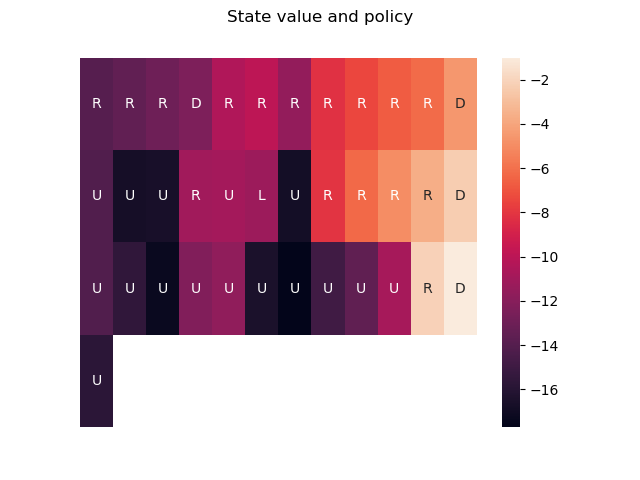

In [ ]:
plot_state_value_and_policy(mc_agent)

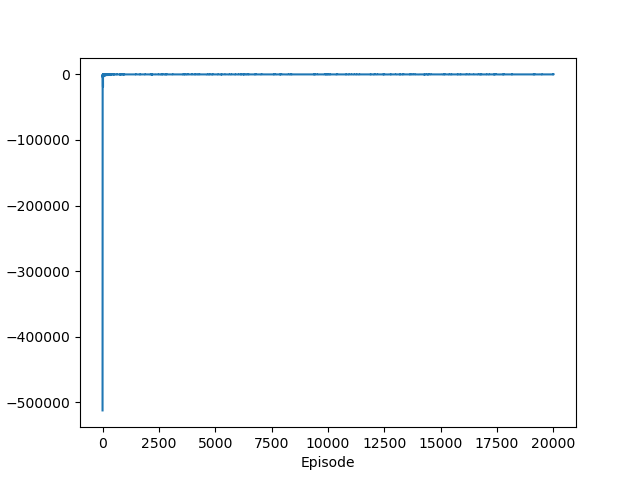

In [ ]:
fig, ax = plt.subplots()
plt.xlabel('Episode')
plt.ylabel('Return')
sns.lineplot(mc_training_returns, ax=ax);

### Assignment questions:

1. Have a look at the Monte Carlo agent's `train` function. How is the Q function updating process different from that of the temporal difference agents?
2. Sometimes MC can get stuck in an episode for a long time, why is this?
3. Does the learned policy look more like the SARSA or Q-learning agent's, why?

### Solutions

1. The MC agent's `train` function takes a list of transitions and iterates through them in reverse order, to calculate the (discounted) value of taking the action that it took at each state that the agent found itself in during that episode. If the agent has been in the same state and taken the same action before, it notes this in a tally and then adds this expected value to the previous expected value, dividing the total expected value by the tally to get the average expected value of that state-action pair. This is the number that is stored in the Q function. 
2. In the early stages of the training process, the agent knows little about its environment but with probability `1 - epsilon` is meant to be using its Q function to decide what to do next. In many cases, the call to `np.argmax` that is mean to help it do this actually returns the first value in a tie. The way the environment is configured, this means that the agent chooses to go up a lot more often than any of the other directions. Since the episode continues indefinitely until the agent gets to the goal, we are relying on the `np.random.choice` part of the policy to get us through each of the early episodes... and this can take a long time! You can tweak the `explore_rate` variable to make the agent spend less time just going up in the early episodes, but if you make this too high then (since it remains constant) the agent will continue to make randomly poor choices even as it learns more about the environment. In our next session we will learn how to adjust the exploration rate so that it is higher at first but reduces as the agent learns more.
3. The Q-learning agent learns to navigate the most efficient route to the goal, which is along the edge of the cliff. The SARSA agent appears more risk averse, and the MC agent appears more risk averse still.

#### End of chapter exercises

1. Update the `train` method for the `TD_agent` class so that the exploration rate starts high and then reduces over time. What difference do you think this will make?
2. Train a SARSA agent or a Q-learning agent on a different environment: the gymnasium library's [frozen lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/). Hint: you can re-use the code to build your agent but you will need to update the configuration variables to match the specifications of the new environment (including the `action_lookup` variable to make sense of the visualisations of the agent's behaviour) - check the environment's [documentation](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) for details. To make life slightly easier for the agent, we will set `is_slippery` to `False`: 

```python 
env = gym.make('FrozenLake-v1', desc=None, map_name='4x4', is_slippery=False, render_mode='rgb_array')
```

#### Solutions:

In [59]:
def training_with_decreasing_exploration_rate(self, n_episodes=10001):
    training_returns = []
    for episode in range(n_episodes): 
        # A simple way of doing this is to reduce the explore rate linearly by episode number:
        explore_rate = 1 - episode / (n_episodes - 1)
        episode_reward = self.run_episode(explore_rate)
        training_returns.append(episode_reward)
        if episode % 1000 == 0: # print results of current episode
            print('episode:', episode, ', explore_rate:', explore_rate, ', return:', episode_reward)
    return training_returns

TD_agent.train = training_with_decreasing_exploration_rate

In [49]:
env = gym.make('FrozenLake-v1', desc=None, map_name='4x4', is_slippery=False, render_mode='rgb_array')

n_states = 16
grid_shape = (4, 4) # (Rows, columns)

n_actions = 4
env.action_lookup = {0: 'Left', 1: 'Down', 2: 'Right', 3: 'Up'}
env.mask = np.array([
    [0,0,0,0],
    [0,1,0,1],
    [0,0,0,1],
    [1,0,0,1]
], dtype=bool)

In [55]:
frozen_lake_q_learning_agent = QLearning_agent(env, n_states, n_actions)
print('TRAINING')
frozen_lake_q_learning_returns = frozen_lake_q_learning_agent.train(n_episodes=10001)

TRAINING
episode: 0 , explore_rate: 1.0 , return: 0.0
episode: 1000 , explore_rate: 0.9 , return: 0.0
episode: 2000 , explore_rate: 0.8 , return: 0.0
episode: 3000 , explore_rate: 0.7 , return: 0.0
episode: 4000 , explore_rate: 0.6 , return: 0.0
episode: 5000 , explore_rate: 0.5 , return: 0.0
episode: 6000 , explore_rate: 0.4 , return: 1.0
episode: 7000 , explore_rate: 0.30000000000000004 , return: 1.0
episode: 8000 , explore_rate: 0.19999999999999996 , return: 1.0
episode: 9000 , explore_rate: 0.09999999999999998 , return: 1.0
episode: 10000 , explore_rate: 0.0 , return: 1.0


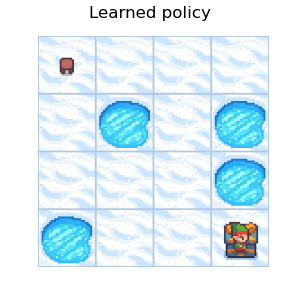

In [56]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.axis('off')
plt.suptitle('Learned policy')
frames = frozen_lake_q_learning_agent.get_learned_policy_as_animation_frames(ax)
ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True, repeat=False);

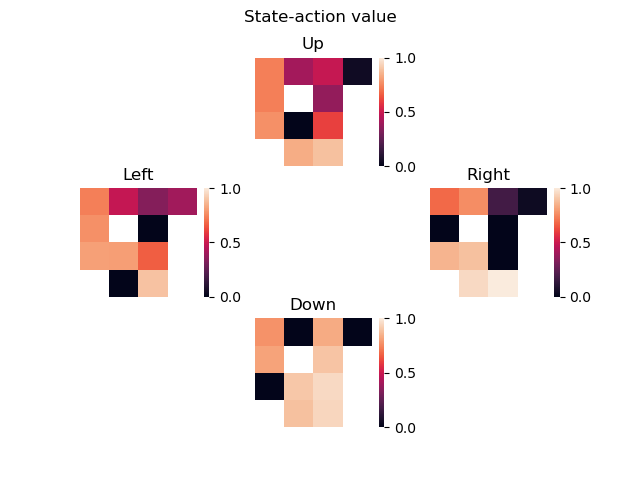

In [57]:
plot_state_action_values(frozen_lake_q_learning_agent)

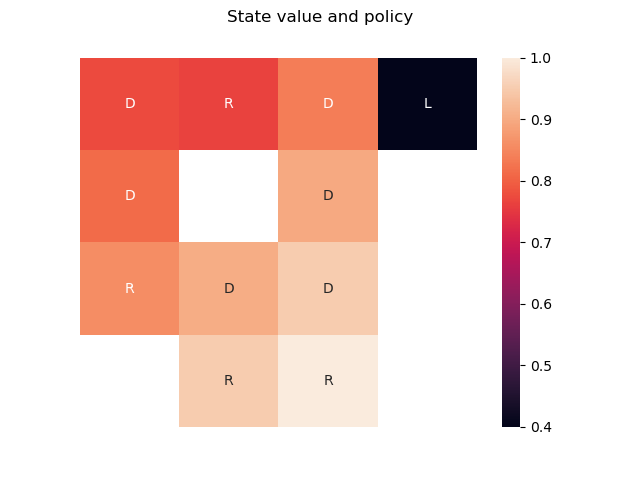

In [58]:
plot_state_value_and_policy(frozen_lake_q_learning_agent)

### Key points

- Reinforcement learning is a category of machine learning in which a simulated agent develops an optimal decision-making process in tandem with a simulated environment
- There are various ways to implement this idea in practice, including SARSA, Q-learning and Monte Carlo, which may result in different optimal behaviours, as in the example above 
- When the simulated environment has a relatively small number of possible states and actions, it is straightforward to visualise the impact that the different approaches to learning have on the agent's behaviour